In [3]:
import numpy as np
import torch
from torch import nn

import matplotlib.pyplot as plt

"""
Github: Yonv1943 Zen4 Jia1 hao2
https://github.com/Yonv1943/DL_RL_Zoo/blob/master/RNN
The source of training data 
https://github.com/L1aoXingyu/
code-of-learn-deep-learning-with-pytorch/blob/master/
chapter5_RNN/time-series/lstm-time-series.ipynb
"""

'\nGithub: Yonv1943 Zen4 Jia1 hao2\nhttps://github.com/Yonv1943/DL_RL_Zoo/blob/master/RNN\nThe source of training data \nhttps://github.com/L1aoXingyu/\ncode-of-learn-deep-learning-with-pytorch/blob/master/\nchapter5_RNN/time-series/lstm-time-series.ipynb\n'

In [4]:
def load_data():
    # passengers number of international airline , 1949-01 ~ 1960-12 per month
    seq_number = np.array(
        [112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
         118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
         114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
         162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
         209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
         272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
         302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
         315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
         318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
         348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
         362., 348., 363., 435., 491., 505., 404., 359., 310., 337., 360.,
         342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.,
         417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
         432.], dtype=np.float32)
    # assert seq_number.shape == (144, )
    # plt.plot(seq_number)
    # plt.ion()
    # plt.pause(1)
    seq_number = seq_number[:, np.newaxis]

    # print(repr(seq))
    # 1949~1960, 12 years, 12*12==144 month
    seq_year = np.arange(12)
    seq_month = np.arange(12)
    seq_year_month = np.transpose(
        [np.repeat(seq_year, len(seq_month)),
         np.tile(seq_month, len(seq_year))],
    )  # Cartesian Product

    seq = np.concatenate((seq_number, seq_year_month), axis=1)

    # normalization
    seq = (seq - seq.mean(axis=0)) / seq.std(axis=0)
    return seq

In [6]:
# LSTM网络包装函数
class RegLSTM(nn.Module):
    def __init__(self, inp_dim, out_dim, mid_dim, mid_layers):
        super(RegLSTM, self).__init__()

        self.rnn = nn.LSTM(inp_dim, mid_dim, mid_layers)  # rnn
        self.reg = nn.Sequential(
            nn.Linear(mid_dim, mid_dim),
            nn.Tanh(),
            nn.Linear(mid_dim, out_dim),
        )  # regression

    def forward(self, x):
        y = self.rnn(x)[0]  # y, (h, c) = self.rnn(x)

        seq_len, batch_size, hid_dim = y.shape
        y = y.view(-1, hid_dim)
        y = self.reg(y)
        y = y.view(seq_len, batch_size, -1)
        return y

    """
    PyCharm Crtl+click nn.LSTM() jump to code of PyTorch:
    Examples::
        >>> rnn = nn.LSTM(10, 20, 2)
        >>> input = torch.randn(5, 3, 10)
        >>> h0 = torch.randn(2, 3, 20)
        >>> c0 = torch.randn(2, 3, 20)
        >>> output, (hn, cn) = rnn(input, (h0, c0))
    """

    def output_y_hc(self, x, hc):
        y, hc = self.rnn(x, hc)  # y, (h, c) = self.rnn(x)

        seq_len, batch_size, hid_dim = y.size()
        y = y.view(-1, hid_dim)
        y = self.reg(y)
        y = y.view(seq_len, batch_size, -1)
        return y, hc

In [40]:
def run_origin():
    inp_dim = 3
    out_dim = 1
    mod_dir = '.'

    '''load data'''
    data = load_data()  # axis1: number, year, month
    #data_x = np.concatenate((data[:-2, 0:1], data[+1:-1, 0:1]), axis=1)
    #data_y = data[2:, 0]

    data_x = data[:-1, :] # all data set
    data_y = data[+1:, 0] # 客流量
    
    train_size = int(len(data_x) * 0.75)
    train_x = data_x[:train_size]
    train_y = data_y[:train_size]

 #需要将数据改变一下形状，因为 RNN 读入的数据维度是 (seq, batch, feature)，
 #所以要重新改变一下数据的维度，这里只有一个序列，所以 batch 是 1，
    
    train_x = train_x.reshape((-1, 1, 3)) # inp_dim?
    train_y = train_y.reshape((-1, 1, 1))

    '''build model'''
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = RegLSTM(inp_dim, out_dim, mid_dim=4, mid_layers=2).to(device)
    criterion = nn.SmoothL1Loss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

    '''train'''
    var_x = torch.tensor(train_x, dtype=torch.float32, device=device)
    var_y = torch.tensor(train_y, dtype=torch.float32, device=device)
    print('var_x.size():', var_x.size())
    print('var_y.size():', var_y.size())

    for e in range(512):
        out = net(var_x)
        loss = criterion(out, var_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (e + 1) % 100 == 0:  # 每 100 次输出结果
            print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))

    torch.save(net.state_dict(), '{}/net.pth'.format(mod_dir))

    '''eval'''
    # net.load_state_dict(torch.load('{}/net.pth'.format(mod_dir), map_location=lambda storage, loc: storage))
    net = net.eval()  # 转换成测试模式

    """
    inappropriate way of seq prediction: 
    use all real data to predict the number of next month
    """
    test_x = data_x.reshape((-1, 1, inp_dim))
    var_data = torch.tensor(test_x, dtype=torch.float32, device=device)
    eval_y = net(var_data)  # 测试集的预测结果
    pred_y = eval_y.view(-1).cpu().data.numpy()

    plt.plot(pred_y[1:], 'r', label='Prediction', alpha=0.3)
    plt.plot(data_y, 'b', label='real', alpha=0.3)
    plt.plot([train_size, train_size], [-1, 2], label='train | pred')
    
    plt.legend(loc='best')
    plt.savefig('lstm_origin.png')
    plt.pause(4)

    """
    appropriate way of seq prediction: 
    use real+pred data to predict the number of next 3 years.
    """
    #test_x = data_x.reshape((-1, 1, inp_dim))
    #test_x[train_size:] = 0  # delete the data of next 3 years.
    #test_x = torch.tensor(test_x, dtype=torch.float32, device=device)
    #for i in range(train_size, len(data) - 2):
    #    test_y = net(test_x[:i])
    #    test_x[i, 0, 0] = test_x[i - 1, 0, 1]
    #    test_x[i, 0, 1] = test_y[-1, 0]
    #pred_y = test_x.cpu().data.numpy()
    #pred_y = pred_y[:, 0, 0]
    #plt.plot(pred_y[2:], 'g', label='pred appr')

    #plt.legend(loc='best')
    #plt.savefig('lstm_origin.png')
    #plt.pause(4)

var_x.size(): torch.Size([107, 1, 3])
var_y.size(): torch.Size([107, 1, 1])
Epoch: 100, Loss: 0.01505
Epoch: 200, Loss: 0.00413
Epoch: 300, Loss: 0.00244
Epoch: 400, Loss: 0.00178
Epoch: 500, Loss: 0.00131


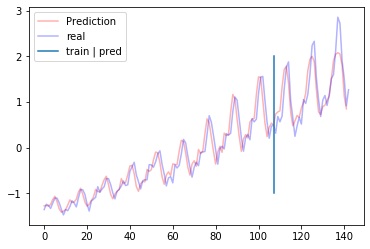

In [41]:
if __name__ == '__main__':
    #run_train_lstm()
    # run_train_gru()
     run_origin()